#### Aug. 9, 2018 1pm

In [58]:
# GLOBAL Variables for running code segments

showPlots = True
verbose   = False

In [59]:
import numpy   as np
import pandas  as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing   import scale, StandardScaler
from sklearn.decomposition   import PCA, TruncatedSVD

import re
import pickle
from nltk.corpus import stopwords

---

#### Function Definitions

In [60]:
def time_Now():
    import datetime
    import pytz
    utc_now = pytz.utc.localize(datetime.datetime.utcnow())
    pst_now = utc_now.astimezone(pytz.timezone("America/Los_Angeles"))
    return (pst_now)

In [61]:
import itertools 

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
        This function prints and plots the confusion matrix CM that is passed in:
        cm, classes,
        Normalization can be applied by setting 'normalize=True'.
        Figure title
        cmap color scheme
    """
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label', fontsize=14)
    plt.xlabel('Predicted label', fontsize=14)

In [62]:
def RF_feature_importance(forest, X, importances):
    std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(X.shape[1]):
        print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

    # Plot the feature importances of the forest
    plt.figure(figsize=(12,10))
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
    plt.xticks(range(X.shape[1]), indices)
    plt.xlim([-1, X.shape[1]])

In [63]:
def RF_top_words(RF_model, stop = 50):

    importances = RF_model.feature_importances_
    indices = np.argsort(importances)[::-1]
    indices = indices.reshape(1,n_comps)
    
    important_words = svd.inverse_transform(np.array(indices))

    iw_ind = np.argsort(important_words)[::-1]

    inds = iw_ind[:,:stop].reshape(stop)
    print( np.array(ftrs)[iw_ind[:,:stop].reshape(stop)] )

In [64]:
def plot_model_ROC(model, X_df, y_true):
    
    y_score = model.predict_proba(X_df)[:,1]

    fpr, tpr, thresholds = roc_curve(y_true, y_score, pos_label=1)

    plt.figure(figsize=(12,10))
    plt.plot(fpr, tpr, 'o--')
    plt.plot(np.linspace(0,1), np.linspace(0,1), 'k--')
    plt.ylabel("True Positive Rate",  fontsize=14)
    plt.xlabel("False Positive Rate", fontsize=14);
    plt.text(.6, .1, "AUC score: {0:.4f}".format( roc_auc_score(y_test, y_score) ), fontsize=14);

---
### Modified: 

In [65]:
print("Last modified on: ", time_Now())

Last modified on:  2018-08-11 14:42:13.662371-07:00


---

### Large Pickled Dataset



In [66]:
%%time
df = pd.read_pickle("newRev_VegCols_US.pkl")

CPU times: user 836 ms, sys: 528 ms, total: 1.36 s
Wall time: 1.36 s


In [67]:
X_df = df.drop(['vegFriendly', 'Vegan', 'Vegetarian'], axis=1)
y_df = df['vegFriendly']

In [68]:
if verbose:
    X_df.info()

In [69]:
%%time
X_df.iloc[:, 5] = X_df['text'].apply( lambda rev: re.sub(r'(\d+)', '', rev) )

CPU times: user 15.6 s, sys: 0 ns, total: 15.6 s
Wall time: 15.6 s


In [70]:
%%time
X_df.iloc[:, 5] = X_df['text'].apply( lambda rev: rev.replace('_', '') )

CPU times: user 772 ms, sys: 0 ns, total: 772 ms
Wall time: 771 ms


In [71]:
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.3)

In [72]:
print( X_train.shape, X_test.shape)

(646101, 17) (276901, 17)


---

### Manipulate data sets

In [73]:
stopWords = list(stopwords.words('english'))
stopWords.extend(['good', 'excellent', 'best', 'like', 'place', 'really', 'ordered', 'amazing', 'fantastic', 'am', 'pm'])
stopWords.extend(['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaa', 'aaaaaaaaaaaaaaaaaaaaaaaaaauuuuuuuuuuuuuuuuggggggggggggggggggg', 'aaaaaaah'])
stopWords.extend(['aaaaaaamazing', 'aaaaaaand', 'aaaaaamazing', 'aaaaahhhh', 'aaaaahhhhhhmazing', 'aaaaahhhhmaaazeballs', 'aaaaamazing', 'aaaaand'])
stopWords.extend(['aaaack', 'aaaamazing', 'aaaammmazziiigggg', 'aaaand', 'aaaarrgh', 'aaah', 'aaahh'])
stopWords.extend(['aaahhhh', 'aaahhhhh', 'aaahhhhmmmaaazzziiiinnnnggg'])
stopWords.extend(['aaammaziiiing', 'aaand', 'aab', 'aaboud', 'aac', 'aachi', 'aadd', 'aaggh', 'aagh', 'aah', 'aahan', 'aahc', 'aahhh'])
stopWords.extend(['aahhhh', 'aahhhhhh', 'aahhhhhhmazing', 'aahhhhhmazing', 'aahhhhmazing', 'aahing', 'aahran'])
stopWords.extend(['aaaaaaaaaa', 'aaaaaaaaaaaaaand', 'aaaaaaaaaaaaaauthentic', 'aaaaaaaaaaaaaawwwwwwwwwwwwwwwwwwwwww', 'aaaaaaaaaaack', 'aaaaaaaaaaah', 'aaaaaaaaaand', 'aaaaaaaaargh', 'aaaaaaaack', 'aaaaaaaahhhhhhhhh', 'aaaaaaaamazing', 'aaaaaaaand', 'aaaaaaall', 'aaaaaaamaaaaazing', 'aaaaaaammmmazing', 'aaaaaahhhh', 'aaaaaahhhhh', 'aaaaaahhhhhmazing', 'aaaaaand', 'aaaaaannnddd', 'aaaaaannnndddd', 'aaaaagh', 'aaaaah', 'aaaaahhhhmazing', 'aaaaamaaazing', 'aaaaammmaazzzinnngg', 'aaaaarrrggghh', 'aaaaawful', 'aaaaay', 'aaaagh', 'aaaah', 'aaaahh', 'aaaahhh', 'aaaahhhh', 'aaaahhhhhhh', 'aaaahmazzzing', 'aaaajúa', 'aaaall', 'aaaalllllllll', 'aaaallright', 'aaaammaaazzinnnggg', 'aaaammazzing', 'aaaammmaaaaazzzziiiinnnngggg', 'aaaammmaaazing', 'aaaammmmmmazing', 'aaaamzing', 'aaaandd', 'aaaanddd', 'aaaannnd', 'aaaannnnd', 'aaaanyway', 'aaaawesoooome', 'aaaawwwesome', 'aaaawwwww', 'aaagggrrrrrrrhhhhh', 'aaahahaa', 'aaahhh', 'aaahhhhhhh', 'aaahhhs', 'aaahing', 'aaahmaaaazing', 'aaahmazing', 'aaahs', 'aaaiiiiight', 'aaall', 'aaallll', 'aaalways', 'aaamaazing', 'aaamazing', 'aaammaaazzziinnnngggg', 'aaammazing', 'aaammmazing', 'aaammmazinggggg', 'aaammmmaaazzziinnggg', 'aaannd', 'aaanndd', 'aaannndd', 'aaannnnd', 'aaanyway', 'aaare', 'aaawwee', 'aaawww', 'aaawwwwsome', 'aaay', 'aacross', 'aadbcc', 'aadorbsssssss', 'aagain', 'aahaan', 'aahed', 'aahh', 'aahs', 'aaid', 'aaiight', 'aaiiight', 'aaim', 'aaka', 'aaked', 'aaliyah', 'aall'])

In [74]:
vectorizer = TfidfVectorizer(stop_words=stopWords, strip_accents = 'ascii' )

#### Vectorize Review Text

In [75]:
%%time
X_train_term  = vectorizer.fit_transform(X_train['text'])

CPU times: user 44.1 s, sys: 612 ms, total: 44.7 s
Wall time: 44.7 s


In [76]:
X_train_term.shape

(646101, 138033)

In [77]:
ftrs = vectorizer.get_feature_names()

In [78]:
if verbose:
    print(ftrs[900:1000])

In [79]:
if verbose:
    print(ftrs[:100])

#### Reduce Dimensionality

In [80]:
n_comps = 12 #120
svd = TruncatedSVD(n_components = n_comps, n_iter=7)

In [81]:
%%time
X_train_term_svd = svd.fit_transform(X_train_term)  

CPU times: user 44.7 s, sys: 2.9 s, total: 47.6 s
Wall time: 16.7 s


In [82]:
svd.singular_values_

array([130.630058  ,  58.95163781,  57.13837405,  54.4826822 ,
        50.77459555,  45.65004361,  45.23572374,  43.21722734,
        41.89762379,  39.85886228,  38.49794907,  38.42569701])

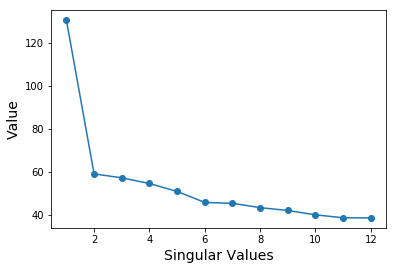

In [83]:
if showPlots:
    s = svd.singular_values_

    x = [i+1 for i in range(len(s))]
    plt.plot(x, s, marker='o')
    plt.xlabel("Singular Values", fontsize=14)
    plt.ylabel("Value",  fontsize=14);

---

### Percentage of Variance Explained

In [84]:
print("Percentage of explained variance (dimRed)", svd.explained_variance_ratio_.sum()*100)

Percentage of explained variance (dimRed) 4.18163813745961


---

#### Random Forest - Train

In [85]:
from sklearn.ensemble import RandomForestClassifier

In [86]:
%%time
n_trees = 8 #800
RF_model = RandomForestClassifier(n_jobs=-1, n_estimators = n_trees)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 52 µs


In [87]:
%%time
RF_model.fit(X_train_term_svd, y_train)

CPU times: user 41.3 s, sys: 156 ms, total: 41.4 s
Wall time: 5.48 s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=8, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

---

#### Pickle models

In [88]:
import pickle

In [89]:
# pickle.dump(vectorizer, open('pkl_tfidf_stpWds.p','wb'))
# pickle.dump(svd, open('pkl_svd_120_comp.p','wb'))
# pickle.dump(RF_model, open('pkl_rf_800_trees.p','wb'))

---

#### Random Forest - Test

In [90]:
%%time
X_test_term = vectorizer.transform(X_test['text'])

CPU times: user 19.4 s, sys: 144 ms, total: 19.6 s
Wall time: 19.5 s


In [91]:
X_test_term.shape

(276901, 138033)

In [92]:
%%time
X_test_term_svd = svd.transform(X_test_term)

CPU times: user 180 ms, sys: 0 ns, total: 180 ms
Wall time: 180 ms


In [93]:
X_test_term_svd.shape

(276901, 12)

In [94]:
%%time
pred = RF_model.predict(X_test_term_svd)

CPU times: user 1.12 s, sys: 0 ns, total: 1.12 s
Wall time: 211 ms


In [95]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

In [96]:
accuracy_score(y_test, pred)

0.8625537647029082

In [97]:
precision_score(y_test, pred)

0.8168198842356146

In [98]:
recall_score(y_test, pred)

0.4233355097143059

In [99]:
f1_score(y_test, pred)

0.5576540871000361

In [100]:
print(classification_report(y_test, pred))

             precision    recall  f1-score   support

        0.0       0.87      0.98      0.92    220232
        1.0       0.82      0.42      0.56     56669

avg / total       0.86      0.86      0.84    276901



Confusion matrix, without normalization


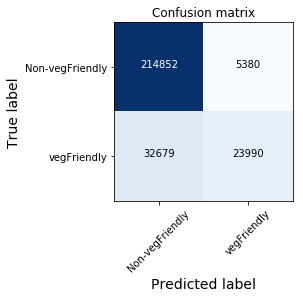

In [101]:
if showPlots:
    cm = confusion_matrix(y_test, pred)
    
    lbls = ['Non-vegFriendly', 'vegFriendly',]

    plot_confusion_matrix(cm, lbls, False)

In [102]:
if verbose:
    RF_top_words(RF_model)

---

#### Plot RF ROC curve

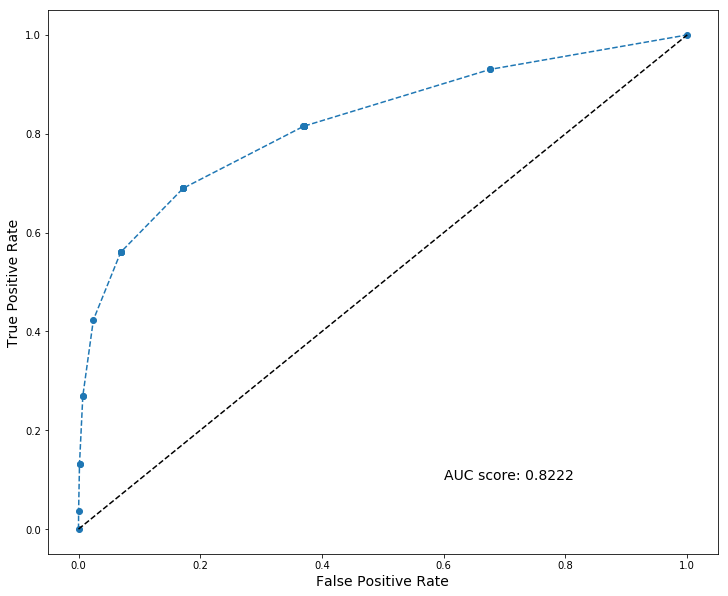

In [103]:
if showPlots:
    plot_model_ROC(RF_model, X_test_term_svd, y_test)

Feature ranking:
1. feature 7 (0.097634)
2. feature 1 (0.088712)
3. feature 11 (0.088350)
4. feature 3 (0.087096)
5. feature 6 (0.084429)
6. feature 8 (0.084335)
7. feature 4 (0.084136)
8. feature 5 (0.079439)
9. feature 9 (0.077655)
10. feature 10 (0.077426)
11. feature 0 (0.075706)
12. feature 2 (0.075082)


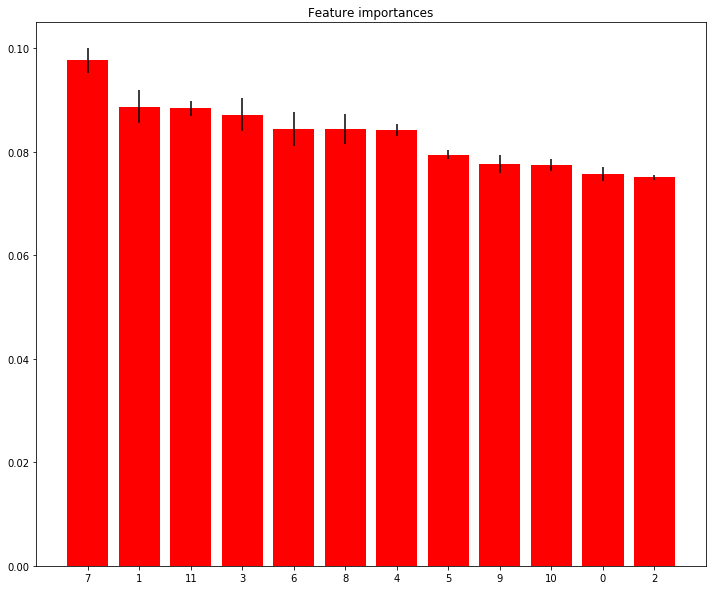

In [104]:
if showPlots:
    importances = RF_model.feature_importances_
    RF_feature_importance(RF_model, X_test_term_svd, importances)

In [48]:
# df['vegFriendly'].value_counts()

# df['useful'].value_counts()[1:10]

# df['useful'].value_counts()[1:].sum() / df['useful'].value_counts().sum()

# df['useful'].value_counts()[1:].sum() 

In [49]:
# y_score = RF_model.predict_proba(X_test_term_svd)[:,1]

# fpr, tpr, thresholds = roc_curve(y_test, y_score, pos_label=1)

# plt.figure(figsize=(12,10))
# plt.plot(fpr, tpr, 'o--')
# plt.plot(np.linspace(0,1), np.linspace(0,1), 'k--')
# plt.ylabel("True Positive Rate",  fontsize=14)
# plt.xlabel("False Positive Rate", fontsize=14);
# plt.text(.6, .1, "AUC score: {0:.4f}".format( roc_auc_score(y_test, y_score) ), fontsize=14);